In [49]:
# preamble. 
import numpy as np # basic vector/matrix math
import matplotlib.pyplot as plt # plotting and illustrations 
import seaborn as sns # advanced plotting and illustrations. 
import pandas as pd # data loading, saving, and general data manipulation. 
import scipy.stats as stats # inter alia, statistical distributions, functions and relevant objects.
import scipy.optimize as optimize 
import torch # ML/AI model's and general optimization 

# needed for this lab 
from sklearn.preprocessing import PowerTransformer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, cross_val_score

# STA 2453 Lab 3 Submission

This lab notebook must be completed in the appropriate time during class and invigilated by the instructor. There are  3 parts in this evaluation, you must add both this notebook, and another generated `.py` file to the PR. 

Once the PR is in place, please tag both me and the TA in it. So in the end you will have two files. 

- `STA2453-Lab-3.ipynb`
- `STA2453-Lab-3.py`

Both of these are needed for a good submission. 







---

## Case Study: The St. Louis Risk Research Project 

---

Was an observational study to assess the affects of parental
psychological disorders on child development. In the preliminary study, 69 families with 2 children were studied. The link to the dataset can be found here: 
`https://utstat.utoronto.ca/~pocucan/st4.csv`

---

This data is collected from a reading scores of 69 famlies with 2 children. 
It contains the following variables:

- `R1` Reading score of child 1

- `V1` Verbal score of child 1

- `R2` Reading score of child 2

- `V2` Verbal score of child 2

---







---

## Part 1 Power Transforms 
---

This part of the evaluation requires you to employ power transforms to transform data from asymmetric to normal. 

Load the `stlouis` dataset in, plot a histogram of the `R1` and `V1` variables, and comment on the shape of them. 

Next, fit a power transform model on the two variables, and plot histograms  of the transformed data for `R1` and `V1`. 

Compare and contrast the before/after histograms for the transformations.


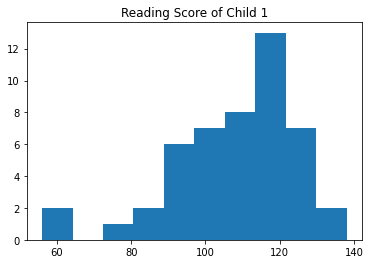

In [169]:
# load the dataset st4 dataset. 
stlouis = pd.read_csv('https://utstat.utoronto.ca/~pocucan/st4.csv').iloc[:,1:]
plt.hist(stlouis.R1)
plt.title('Reading Score of Child 1')
plt.show()

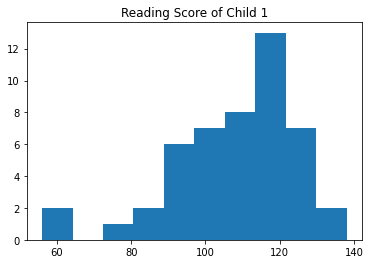

In [ ]:
# load the dataset st4 dataset. 
stlouis = pd.read_csv('https://utstat.utoronto.ca/~pocucan/st4.csv').iloc[:,1:]
# plot histograms of the reading and verbal score for child 1. 
plt.hist(stlouis.R1)
plt.title('Reading Score of Child 1')
plt.show()

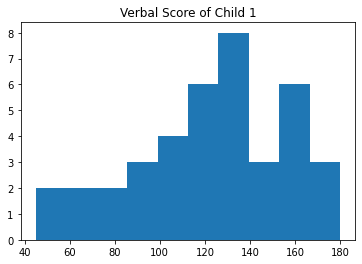

In [11]:
# plot histogram is verbal score of child 1
plt.hist(stlouis.V1)
plt.title('Verbal Score of Child 1')
plt.show()

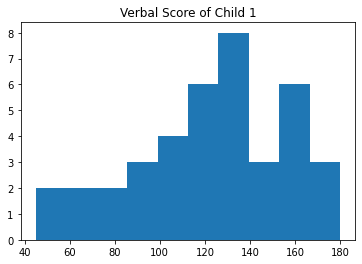

In [ ]:
# plot histogram is verbal score of child 1
plt.hist(stlouis.V1)
plt.title('Verbal Score of Child 1')
plt.show()

The shape of R1 and V1 are left skewed distribution.(asymmetric)

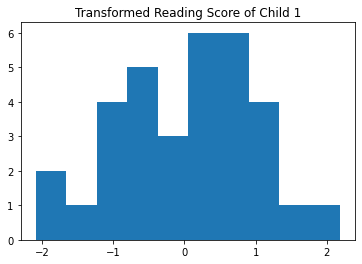

In [93]:
# declare a power transformer 
power = PowerTransformer()
# segment the relevant data for said power transformer
subset = stlouis[['R1','V1']]
# clean the relevant data accordingly. 

# get na mask 
na_mask = subset.isna().any(axis=1) 
df_na = subset.loc[na_mask,:]
df_na
# remove fully missing observations 
df_na = df_na.loc[~df_na.isna().all(axis=1),:].copy()
df_na
# clean 
df_clean = subset.loc[~na_mask,:]
df_clean

# fit the power transformer onto the dataset. 
# R1_trans = power.fit_transform(stlouis.R1)
# V1_trans = power.fit_transform(stlouis.V1)
power.fit(df_clean)
# # transform the data, fit into dataframe. 
subset_trans = power.transform(df_clean)
subset_trans = pd.DataFrame(subset_trans)
subset_trans
# plot histograms. 
# plot histograms of the transformed reading and verbal score for child 1. 
plt.hist(subset_trans[0])
plt.title('Transformed Reading Score of Child 1')
plt.show()

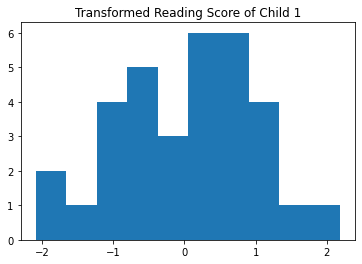

In [45]:
# plot histograms of the transformed reading and verbal score for child 1. 
plt.hist(subset_trans[0])
plt.title('Transformed Reading Score of Child 1')
plt.show()

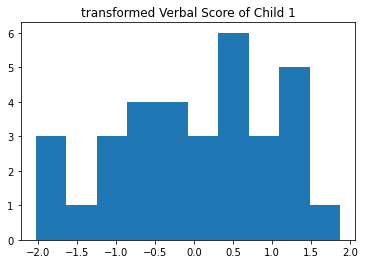

In [44]:
# plot histogram of the transformed verbal score of child 1
plt.hist(subset_trans[1])
plt.title('Transformed Verbal Score of Child 1')
plt.show()

Now the distribution of transformed R1 and V1 are both normal distributed.

---
## Part 2 Imputation
---

Take the original data. Perform an imputation procedure using a GMM model as discussed in class. 

Find the optimal number of G via some metric, show your results. 

Plot a pairsplot with the following schematic: 
- grey points are fully complete datapoints. 
- blue points are imputed datapoints and overlayed with the original grey. 

Comment on the fits and any relationships. 


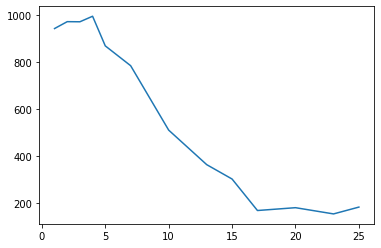

In [170]:
# clean and segment data 
# get na mask 
na_mask = stlouis.isna().any(axis=1) 
df_na = stlouis.loc[na_mask,:]
df_na
# remove fully missing observations 
df_na = df_na.loc[~df_na.isna().all(axis=1),:].copy()
df_na
# clean 
df_clean = stlouis.loc[~na_mask,:]
df_clean
# declare model 
gmm =GaussianMixture()
# fit model on data
# find optimal number of G
bic = np.zeros(13)
n = np.array([1,2,3,4,5,7,10,13,15,17,20,23,25])
models = []
#loop through each number of Gaussians and compute the BIC, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = GaussianMixture(n_components=j)
    #fit it to the data
    gmm.fit(df_clean.to_numpy())
    #compute the BIC for this model
    bic[i] = gmm.bic(df_clean.to_numpy())
    #add the best-fit model with j components to the list of models
    models.append(gmm)
plt.plot(n,bic)
plt.show()

BIC the lower the better. It can be seen that when G=17, we can fit the best model.

In [171]:
def density(xi: np.array, pis: np.array, mus: np.array, Ss:np.array):
    """ 
        Calculate log density of a multivariate normal density
    """
    
    p = xi.shape[0]
    leading_constant = (np.pi * 2.0) ** (- p * 0.5)
    
    xm = xi - mus
    xm = np.expand_dims(xm,axis=0)
    Ss_inv = np.linalg.inv(Ss)
    res = (xm.transpose(1,0,2) @ Ss_inv).transpose(1,0,2)
    res = np.exp( ( -0.5 * (res * xm).sum(-1)) )
   
    # result 
    res = pis * np.sqrt(np.linalg.det(Ss_inv)) * res 
    res = float(leading_constant) * res	
    
    return res 
def conditional_mean_imputation(X: np.array, pis: np.array, mus: np.array, Ss: np.array):
    """
        Calculates cmi imputation based on z, mu, sigma, and x, for partials. 
        
        Takes in a vector x (1,p) 
        
    """

    # get missing vector index. 
    
    mis = pd.DataFrame(X).isna().to_numpy() 

    for i in range(X.shape[0]):
        xi = X[i,:] 
        mi = mis[i,:] 
        # get non missing entries
        xi_d = xi[~mi]

        # get parameters. 
        mu_d = mus[:, ~mi]
        mu_m = mus[:, mi] 
        Ss_dd = Ss[:, ~mi][:,:, ~mi]
        Ss_md = Ss[:, mi][:,:,~mi]
        Ss_mm = Ss[:, mi][:,:,mi]

        # compute conditional means. 
        dd_diff = np.expand_dims(xi_d - mu_d,-1)
        
        # leading matrix term. 
        lmatrix_term = Ss_md @ ( np.linalg.inv(Ss_dd))
        mu_tildes = mu_m + (lmatrix_term @ (dd_diff))[:,:,0] 

        zigs = density(xi_d, pis, mu_d, Ss_dd) 
        zigs = zigs / zigs.sum()
        zigs[0,-1] = 1.0 - zigs[0,:-1].sum()
        zigs = zigs.transpose() 
        xi_m_imputed = (mu_tildes * zigs).sum(0)
        xi[mi] = xi_m_imputed 
            

    return X 


<ipython-input-171-71c0de617949>:53: RuntimeWarning: invalid value encountered in true_divide
  zigs = zigs / zigs.sum()


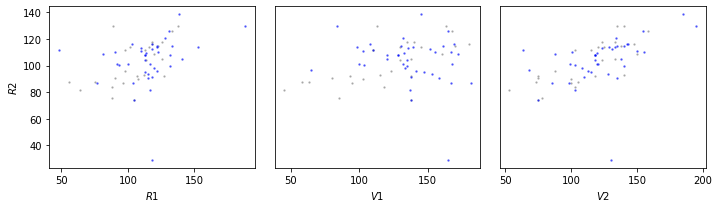

In [172]:
# fit best model 
# fit finite mixture model
G = 17
mm = GaussianMixture(n_components=G)
    
# fit 
mm.fit(df_clean.to_numpy())
# get parameters for imputation 
mus = mm.means_
Ss = mm.covariances_
pis = mm.weights_

# impute dataset 
x_imputed_numpy = conditional_mean_imputation(np.copy(df_na.to_numpy()), pis, mus, Ss);
df_imputed = pd.DataFrame(x_imputed_numpy)    
df_imputed.columns = df_clean.columns 
df_imputed

# plot results. 
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
marker_size = 5.0
alpha = 0.70
marker_color = "grey"

ax1.set_title('')
sns.scatterplot(x='R1', y='R2', data=df_clean, ax=ax1, alpha=alpha, s=marker_size, color=marker_color)
ax1.set_xlabel(r"$R1$")
ax1.set_ylabel(r"$R2$")

ax2.set_title('')
sns.scatterplot(x='V1', y='R2', data=df_clean, ax=ax2, s=marker_size, alpha=alpha, color=marker_color)
ax2.set_xlabel(r"$V1$")
ax2.set_ylabel("")
ax2.axes.get_yaxis().set_visible(False)


ax3.set_title('')
sns.scatterplot(x='V2', y='R2', data=df_clean, ax=ax3, s=marker_size, alpha=alpha, color=marker_color)
ax3.set_xlabel(r"$V2$")
ax3.set_ylabel("")
ax3.axes.get_yaxis().set_visible(False)

fig.tight_layout()

colors = "blue"
edge_color = "lightblue"

sns.scatterplot(x='R1', y='R2', data=df_imputed, ax=ax1, alpha=alpha, s=marker_size, edgecolor=edge_color, color=colors)
sns.scatterplot(x='V1', y='R2', data=df_imputed, ax=ax2, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)
sns.scatterplot(x='V2', y='R2', data=df_imputed, ax=ax3, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)

plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


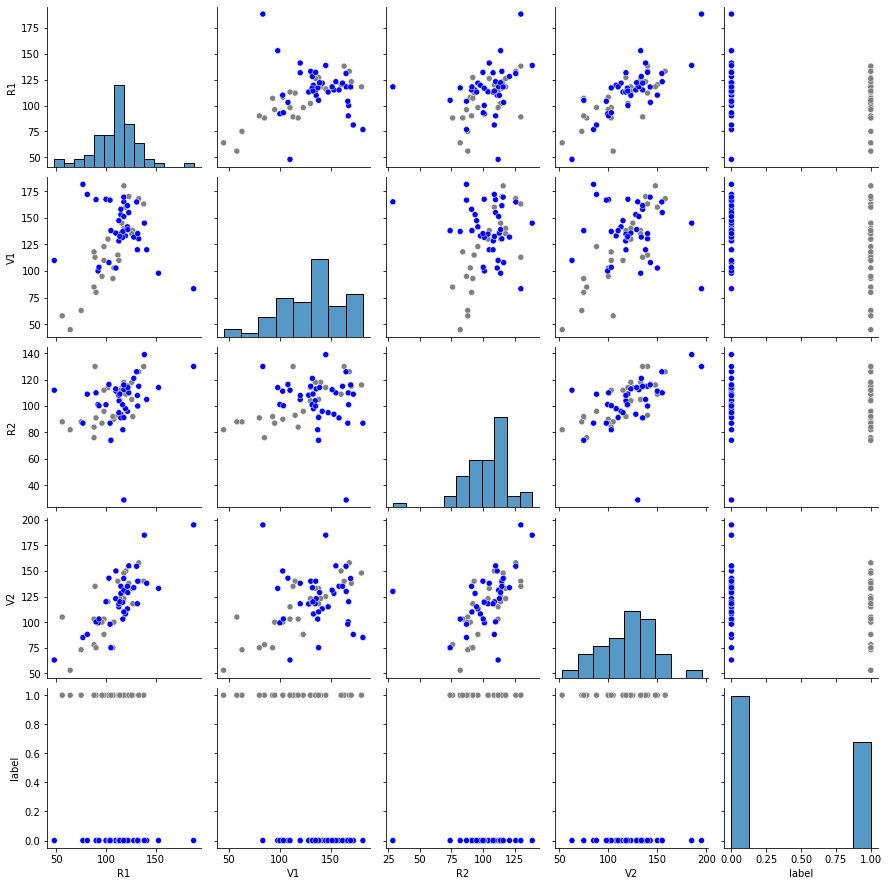

In [173]:
#USING SNS PAIRPLOT
df_clean.loc[:, 'label'] = 1
df_imputed.loc[:, 'label'] = 0
df_new = pd.concat([df_clean, df_imputed], ignore_index=True)
na_mask = df_new.isna().any(axis=1) 
df_new_1 = df_new.loc[~na_mask,:]
df_new_1
colors = df_new_1['label'].apply(lambda x: "grey" if x == 1 else 'blue')
sns.pairplot(df_new_1,plot_kws={'c':colors})

It seems that V2 has linear relationship with R2,and R1 seperately.
R1 has linear relationship with V1.
Some of the blue imputed points are not overlayed the grey points well, but sparse around the graph.

---
## Part 3 Transformation and Imputation 
---

Take the original data. Perform an imputation procedure using a mixture model `AND` a transformation procedure together. 

To achieve a level 3 you must incorporate the transformation coherently, and, fit a mixture model after for imputation purposes. Here, the transformation, and fitting of the mixture model is done `SEPARATELY`. Ensure that during the imputation step you are working in the Gaussian space, and then transform it appropriately to desired domain of the original data. You are free to use any transformation scheme you like, Power transforms, Manly, etc. 

To achieve a level 4 you must adequatly incorporate a transformation `DIRECTLY` within the density of the mixture model component definition, and, fit it appropriately within an estimation step. It is reasonable to assume that if your component-wise distribution is already Gaussian, than your transformation method will still work, just won't be doing much.  

Find the optimal number of G via some metric, show your results. 

Plot a pairsplot with the following schematic: 
- grey points are fully complete datapoints. 
- red points are imputed datapoints and overlayed with the original grey. 

Comment on the impuation and any relationships within the data, compare and contrast the results of the red points vs the blue points from Part 2. 


In [174]:
# clean and segment data 
stlouis = pd.read_csv('https://utstat.utoronto.ca/~pocucan/st4.csv').iloc[:,1:]
# declare a power transformer 
power = PowerTransformer()
# segment the relevant data for said power transformer
# clean the relevant data accordingly. 

# get na mask 
na_mask = stlouis.isna().any(axis=1) 
df_na = stlouis.loc[na_mask,:]
df_na
# remove fully missing observations 
df_na = df_na.loc[~df_na.isna().all(axis=1),:].copy()
df_na
# clean 
df_clean = stlouis.loc[~na_mask,:]
df_clean
power.fit(df_clean)
clean_trans = power.transform(df_clean)
clean_trans = pd.DataFrame(clean_trans)
clean_trans

,0,1,2,3
0,0.474455,0.712519,0.757821,0.431840
1,0.597049,0.553763,0.992216,0.353593
2,1.972694,1.299959,1.674581,1.037610
3,1.114394,0.490819,0.216366,0.750817
4,0.722327,1.200370,0.459512,1.459381
5,0.237265,-0.208989,-0.539504,1.037610
6,1.602936,1.467391,1.450434,1.806722
7,0.597049,1.876439,0.875477,1.373912
8,-0.967701,-1.048296,-1.690747,-1.234786
9,0.010653,-0.555382,-0.735265,-0.501115


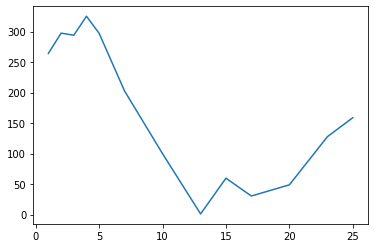

In [147]:
# declare model 
gmm =GaussianMixture()
# fit model on data
# find optimal number of G
bic = np.zeros(13)
n = np.array([1,2,3,4,5,7,10,13,15,17,20,23,25])
models = []
#loop through each number of Gaussians and compute the BIC, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = GaussianMixture(n_components=j)
    #fit it to the data
    gmm.fit(clean_trans.to_numpy())
    #compute the BIC for this model
    bic[i] = gmm.bic(clean_trans.to_numpy())
    #add the best-fit model with j components to the list of models
    models.append(gmm)
plt.plot(n,bic)
plt.show()

BIC the lower the better. It can be seen that when G=13, we can fit the best model.

In [175]:
power.fit(df_na)
na_trans = power.transform(df_na)
na_trans = pd.DataFrame(na_trans)
na_trans

,0,1,2,3
0,-0.323658,NaN,NaN,0.952069
1,0.586953,1.515151,NaN,0.341836
2,NaN,NaN,1.378838,NaN
3,NaN,-0.539579,-0.141252,0.590964
4,NaN,NaN,-0.862120,-0.213139
5,0.217966,0.872618,NaN,NaN
6,NaN,0.483550,2.228079,1.932969
7,NaN,-0.043139,-0.697755,-0.383833
8,NaN,NaN,0.608132,0.652160
9,0.217966,1.131629,NaN,0.498370


In [176]:
# fit best model 
# fit finite mixture model
G = 13
mm = GaussianMixture(n_components=G)
    
# fit 
mm.fit(clean_trans.to_numpy())
# get parameters for imputation 
mus = mm.means_
Ss = mm.covariances_
pis = mm.weights_

# impute dataset within Gaussian space
x_imputed_numpy = conditional_mean_imputation(np.copy(na_trans.to_numpy()), pis, mus, Ss);
df_imputed = pd.DataFrame(x_imputed_numpy)    
# df_imputed.columns = clean_trans.columns 
df_imputed

,0,1,2,3
0,-0.323658,1.063402,0.912918,0.952069
1,0.586953,1.515151,1.928158,0.341836
2,1.309128,1.293775,1.378838,1.651411
3,0.813540,-0.539579,-0.141252,0.590964
4,-0.219652,-0.537289,-0.862120,-0.213139
5,0.217966,0.872618,0.972338,0.231525
6,3.316672,0.483550,2.228079,1.932969
7,0.294642,-0.043139,-0.697755,-0.383833
8,0.938365,0.470695,0.608132,0.652160
9,0.217966,1.131629,0.402644,0.498370


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


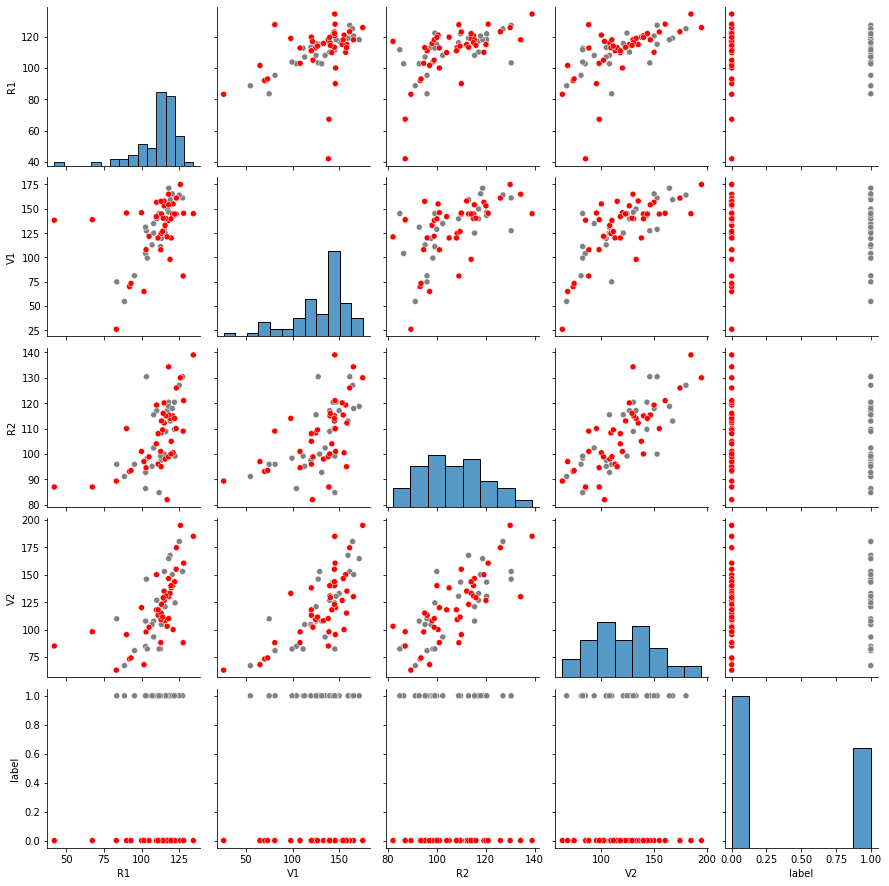

In [177]:
df_inverse_clean = power.inverse_transform(clean_trans)
df_inverse_clean = pd.DataFrame(df_inverse_clean)
df_inverse_clean.columns = stlouis.columns

df_inverse_imputed = power.inverse_transform(df_imputed)
df_inverse_imputed = pd.DataFrame(df_inverse_imputed)
df_inverse_imputed.columns = stlouis.columns
df_inverse_imputed

df_inverse_clean.loc[:, 'label'] = 1
df_inverse_imputed.loc[:, 'label'] = 0
df_inverse_imputed
df_new_trans = pd.concat([df_inverse_clean, df_inverse_imputed], ignore_index=True)
na_mask = df_new_trans.isna().any(axis=1) 
df_new_trans_1 = df_new_trans.loc[~na_mask,:]
df_new_trans_1
colors = df_new_trans_1['label'].apply(lambda x: "grey" if x == 1 else 'red')
sns.pairplot(df_new_trans_1,plot_kws={'c':colors})

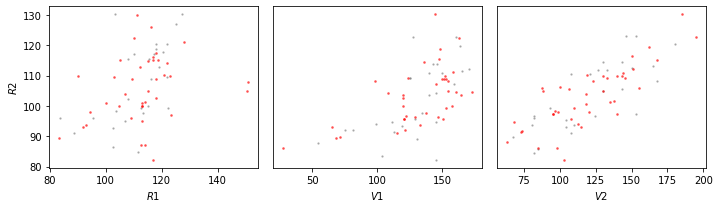

In [168]:
# plot results. 
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
marker_size = 5.0
alpha = 0.70
marker_color = "grey"

ax1.set_title('')
sns.scatterplot(x='R1', y='R2', data=df_inverse_clean, ax=ax1, alpha=alpha, s=marker_size, color=marker_color)
ax1.set_xlabel(r"$R1$")
ax1.set_ylabel(r"$R2$")

ax2.set_title('')
sns.scatterplot(x='V1', y='R2', data=df_inverse_clean, ax=ax2, s=marker_size, alpha=alpha, color=marker_color)
ax2.set_xlabel(r"$V1$")
ax2.set_ylabel("")
ax2.axes.get_yaxis().set_visible(False)


ax3.set_title('')
sns.scatterplot(x='V2', y='R2', data=df_inverse_clean, ax=ax3, s=marker_size, alpha=alpha, color=marker_color)
ax3.set_xlabel(r"$V2$")
ax3.set_ylabel("")
ax3.axes.get_yaxis().set_visible(False)

fig.tight_layout()

colors = "red"
edge_color = "red"

sns.scatterplot(x='R1', y='R2', data=df_inverse_imputed, ax=ax1, alpha=alpha, s=marker_size, edgecolor=edge_color, color=colors)
sns.scatterplot(x='V1', y='R2', data=df_inverse_imputed, ax=ax2, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)
sns.scatterplot(x='V2', y='R2', data=df_inverse_imputed, ax=ax3, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)

plt.show()

Compared with the performance of part 2, red one performs better, since we transformed the skewed data to normal and apply imputation after it. It can be seen that the red points overlayed well on the original grey points, showing linear relationship stated in part2. Some points are sparse still but the number of them are less.

In [ ]:
# based on this approach, the tails are captured much better, data is imputed clearly. 